In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *

In [3]:
import os
path_to_data = Path('data')
path_to_data.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/models'),
 PosixPath('data/data_clas.pkl'),
 PosixPath('data/data_lm.pkl'),
 PosixPath('data/test.csv'),
 PosixPath('data/test.csv.zip'),
 PosixPath('data/test_labels.csv'),
 PosixPath('data/test_labels.csv.zip'),
 PosixPath('data/train.csv'),
 PosixPath('data/train.csv.zip')]

In [12]:
#Unzip file downloaded from kaggle website
import zipfile
with zipfile.ZipFile(str(path_to_data)+"/train.csv.zip" , 'r') as zip_ref:
    zip_ref.extractall(path_to_data)
    
with zipfile.ZipFile(str(path_to_data)+"/test.csv.zip" , 'r') as zip_ref:
    zip_ref.extractall(path_to_data)

with zipfile.ZipFile(str(path_to_data)+"/test_labels.csv.zip" , 'r') as zip_ref:
    zip_ref.extractall(path_to_data)

In [4]:
path_to_data.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/models'),
 PosixPath('data/data_clas.pkl'),
 PosixPath('data/data_lm.pkl'),
 PosixPath('data/test.csv'),
 PosixPath('data/test.csv.zip'),
 PosixPath('data/test_labels.csv'),
 PosixPath('data/test_labels.csv.zip'),
 PosixPath('data/train.csv'),
 PosixPath('data/train.csv.zip')]

## Data

In [6]:
df = pd.read_csv(str(path_to_data) + "/train.csv")

In [15]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Language Model

In [5]:
path = Path(path_to_data)
path.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/models'),
 PosixPath('data/data_clas.pkl'),
 PosixPath('data/data_lm.pkl'),
 PosixPath('data/test.csv'),
 PosixPath('data/test.csv.zip'),
 PosixPath('data/test_labels.csv'),
 PosixPath('data/test_labels.csv.zip'),
 PosixPath('data/train.csv'),
 PosixPath('data/train.csv.zip')]

In [6]:
#Batch size
bs=24

In [9]:
#Create a databunch for our Language Model
data_lm = (TextList.from_df(df, cols=1).split_by_rand_pct(0.1).label_for_lm().databunch(bs=bs)) 

In [19]:
data_lm.save(str(path) + '/data_lm.pkl')

In [7]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch(5)

idx,text
0,". xxmaj he seems to care more about the formatting than the actual info . xxbos "" \n xxmaj more \n i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of "" "" types of accidents "" "" xxup -i think the references may need tidying so that they are all in the"
1,"in place . xxmaj makes me feel real good about your judgement in xxunk me . xxmaj sorta . xxmaj everyme "" xxbos "" \n i am gratified that you have truthfully explained your assumptions of bad faith . i dislike dishonesty more than most . i endeavor to keep xxmaj the xxmaj big xxmaj boys honest , which includes you since you immigrated over here , so do"
2,"xxmaj thank you , best wishes . xxbos "" \n \n xxmaj gatherer xxmaj code \n \n xxmaj there is another internal to xxup xxunk code for each set . xxmaj the code is used in "" "" xxmaj gatherer "" "" when an expansion set is chosen in the advanced search . xxmaj sometimes these codes match up to the internal code that is already here but"
3,"xxunk "" "" . xxmaj my goal was to add some more description to what hoodoo is by discussing some of the underlying symbolism and worldview . i 'm missing a quote that i have n't been able to track down , in xxmaj hyatt 's book vol 1 xxmaj hoodoo - xxmaj xxunk and xxunk , there is an xxunk who says something along the lines of , """
4,"n't consensus to delete at that point . ) ✽ \n \n "" xxbos xxmaj xxunk ] ] 19:02 , 3 xxmaj jan 2004 ( xxup utc ) xxbos "" \n \n xxup prep vs. xxmaj quick xxmaj count \n \n xxmaj the text of the article suggests ( and states overtly at least once ) that the xxup prep and the xxmaj quick xxmaj count are"


In [21]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [23]:
learn.lr_find(num_it=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


With suggestion=True in learn.recorder.plot, we will see the point where the gardient is the steepest

Min numerical gradient: 2.29E-02
Min loss divided by 10: 6.92E-03


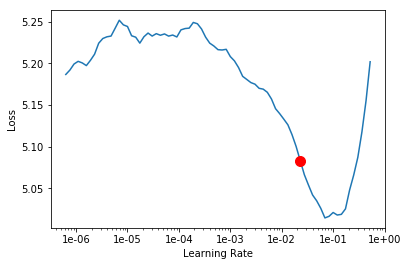

In [24]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [25]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.022908676527677745

In [26]:
learn.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.320640,4.114595,0.309839,47:33


In [27]:
learn.save('fit_head')

In [28]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(5, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.425241,4.394435,0.287190,54:20
1,4.378030,4.321069,0.295596,54:19
2,4.116281,4.167389,0.311328,54:23
3,3.979223,3.966848,0.334828,54:22
4,3.956095,3.866158,0.348071,54:23


In [31]:
learn.save('fine_tuned')

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state.

In [32]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels.

In [10]:
valid_test = pd.read_csv(str(path) + '/test.csv')

test_datalist = TextList.from_df(valid_test, cols='comment_text', vocab=data_lm.vocab)

In [11]:
data_clas = TextList.from_csv(path, 'train.csv', cols='comment_text', vocab=data_lm.vocab)\
                .split_by_rand_pct(0.1)

In [12]:
data_clas = data_clas.label_from_df(cols=['toxic', 'severe_toxic', 'obscene', 'threat',  'insult', 'identity_hate'])
data_clas

LabelLists;

Train: LabelList (143614 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types of accidents " " xxup -i

In [13]:
data_clas = data_clas.add_test(test_datalist)

In [14]:
data_clas = data_clas.databunch(bs=bs)

In [15]:
data_clas.show_batch(5)

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
xxbos xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself ! xxmaj go fuck yourself,toxic;severe_toxic;obscene;insult
"xxbos "" \n \n xxmaj what were you ranting about ? \n \n xxmaj are you talking to me , or the 300 + people who 've downloaded this refutation of you and your uncivil friends ? : http : / / www.mininova.org / tor / 1264745 \n \n xxmaj and so that everyone can see part of it here : \n \n joshuaz said :",
"xxbos "" = = xxmaj macedonians / xxmaj macedonian xxmaj slavs = = \n \n i was under impression that the name of the article would change to a compromising variant : xxmaj macedonians ( nation ) , xxmaj macedonians ( nationality ) , xxmaj macedonians ( people ) or whatever since the resources shown clearly point that xxmaj macedonian xxmaj slavs is rather inappropriate . i 'm glad",
"xxbos "" \n \n xxmaj where does it say that featured articles have different requirements then other articles ? xxmaj jeepday \n \n xxmaj the whole point in to get citations for all articles so that they meet the xxup wp : v requirements , i have noticed that tags quite often help by bringing this to attention of users , particularly new - ish users . xxmaj",toxic;severe_toxic;obscene;insult


In [27]:
data_clas.save('data_clas.pkl')

In [8]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [10]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (143614 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

In [ ]:
learn.freeze()

In [31]:
#Check the number of labels
data_clas.c

6

In [32]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.51E-02


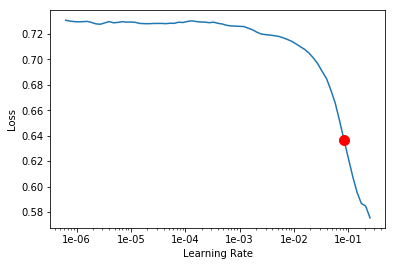

In [33]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [34]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.08317637711026708

In [35]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(min_grad_lr/(2.6**4),min_grad_lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.093102,1.029371,33:53


In [36]:
learn.save('classifier')

In [11]:
learn.load('classifier')
learn.show_results()

text,target,prediction
"xxbos "" xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k xxrep 5 = xxup you ! f xxup uu c xxup kk xxup you xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k xxrep 5 = xxup you ! f xxup uu c xxup kk xxup you xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k xxrep 5 = xxup",toxic;severe_toxic;obscene;insult,
xxbos xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup,toxic,toxic;obscene;insult
"xxbos xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist",toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult
"xxbos "" \n \n \n xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup mongo ? xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup mongo ? xxup mongo , tell us . xxup why xxup did xxup you xxup do xxup wtc ? xxmaj why xxup",toxic,
"xxbos i xxup can xxup still xxup post xxup with xxup this xxup computer ... i xxup said xxup block xxup me , xxup come xxup the xxup fuck xxup down xxup here xxup and xxup arrest xxup me ... xxup san xxup diego xxup california , xxup chula xxup vista , xxup fucking xxup get xxup your xxup information xxup right xxup faggot shithead!!i xxup can xxup still xxup",toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult


## Evaluate results

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

In [13]:
# Predict on the validation dataset
y_pred, y_true = learn.get_preds()

In [14]:
f1_score(y_true, y_pred>0.35, average='micro')

0.549812030075188

In [15]:
y_test = y_true.numpy()
scores = y_pred.numpy()

In [16]:
scores.shape, y_test.shape

((15957, 6), (15957, 6))

In [17]:
scores

array([[9.986725e-02, 4.393694e-03, 3.526842e-02, 4.282800e-03, 4.319565e-02, 8.465736e-03],
       [9.999990e-01, 9.992269e-01, 9.999998e-01, 5.373360e-01, 9.999743e-01, 8.795670e-01],
       [1.545954e-01, 8.048576e-03, 5.606521e-02, 6.518110e-03, 6.890259e-02, 1.324652e-02],
       [3.803169e-02, 1.348885e-03, 1.369647e-02, 1.754095e-03, 1.618589e-02, 3.736801e-03],
       ...,
       [8.461995e-02, 3.553905e-03, 3.014542e-02, 3.633521e-03, 3.672242e-02, 7.261533e-03],
       [6.119698e-02, 2.172017e-03, 2.309149e-02, 2.166385e-03, 2.418558e-02, 5.367334e-03],
       [4.690156e-03, 8.930087e-05, 2.048956e-03, 1.908210e-04, 1.780238e-03, 4.487072e-04],
       [2.859967e-01, 1.647256e-02, 1.096890e-01, 8.071828e-03, 1.434936e-01, 1.790118e-02]], dtype=float32)

In [18]:
y_test

array([[0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [19]:
metrics = classification_report(y_test, scores>0.85, target_names=data_clas.valid_ds.classes)
print(metrics)

               precision    recall  f1-score   support

        toxic       0.93      0.28      0.44      1573
 severe_toxic       0.30      0.27      0.28       169
      obscene       0.93      0.47      0.63       845
       threat       0.05      0.13      0.07        46
       insult       0.77      0.35      0.48       795
identity_hate       0.08      0.04      0.05       113

    micro avg       0.74      0.33      0.46      3541
    macro avg       0.51      0.26      0.33      3541
 weighted avg       0.83      0.33      0.47      3541
  samples avg       0.03      0.03      0.03      3541



/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
micro_roc_auc_ovo = roc_auc_score(y_test, scores, multi_class="ovo",
                                  average="micro")
micro_roc_auc_ovo

0.8993173966356873

In [24]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

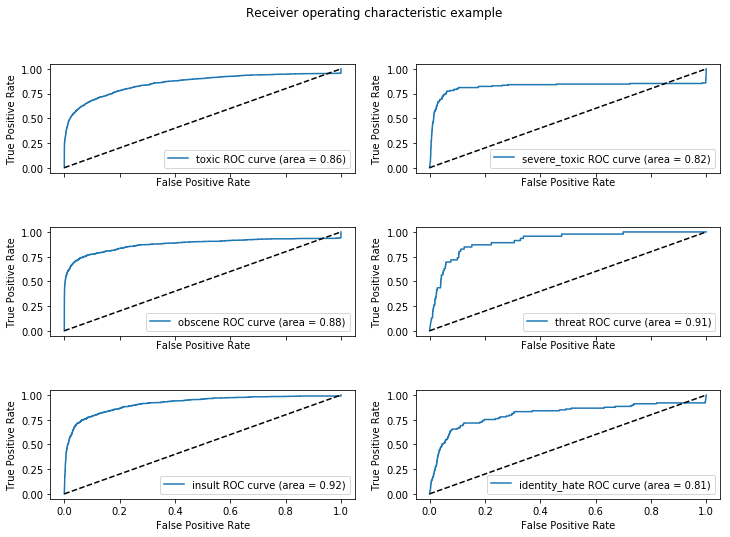

In [50]:
# Plot of a ROC curve for a specific class
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(12, 8))
fig.subplots_adjust(hspace=.5)
fig.suptitle('Receiver operating characteristic example')

i=0
axs[0, 0].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[0, 0].plot([0, 1], [0, 1], 'k--')
axs[0, 0].legend(loc="lower right")

i=1
axs[0, 1].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[0, 1].plot([0, 1], [0, 1], 'k--')
axs[0, 1].legend(loc="lower right")

i=2
axs[1, 0].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[1, 0].plot([0, 1], [0, 1], 'k--')
axs[1, 0].legend(loc="lower right")

i=3
axs[1, 1].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[1, 1].plot([0, 1], [0, 1], 'k--')
axs[1, 1].legend(loc="lower right")

i=4
axs[2, 0].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[2, 0].plot([0, 1], [0, 1], 'k--')
axs[2, 0].legend(loc="lower right")

i=5
axs[2, 1].plot(fpr[i], tpr[i], label=str(data_clas.valid_ds.classes[i]) + ' ROC curve (area = %0.2f)' % roc_auc[i])
axs[2, 1].plot([0, 1], [0, 1], 'k--')
axs[2, 1].legend(loc="lower right")

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

plt.show()
